In [28]:
# this is to suppress 
def warn(*args, **kwargs):
    pass
import warnings

warnings.warn = warn

from collections import defaultdict

from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import RidgeCV, SGDRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_squared_error as mse,
                             mean_squared_log_error as msle,
                             mean_absolute_error as mae,
                             r2_score, accuracy_score, classification_report)
from sklearn.base import clone

from IPython.display import display, HTML, Image

from plot_utils import (plot_regressor_output, compare_model_performance, plot_residual_distribution,
                        plot_monthly_finance_distributions, plot_week_over_week_transactions,
                        plot_features_correlation, visualize_finances, plot_transaction_type_dist)

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
%matplotlib notebook

sns.set_style('whitegrid')

## Dataset Load & Transform
---
todo

In [3]:
ds = pd.read_csv('2016-09-19_79351_training.csv')
ds = ds.sample(frac=1).reset_index()

mcc_lookup = pd.read_csv('mcc_group_definition.csv').set_index('mcc_group').to_dict()
transaction_type_lookup = pd.read_csv('transaction_types.csv').set_index('type').to_dict()

In [4]:
def transform_dataset(ds, copy=False):
    if copy:
        ds = ds.copy()
    ds.transaction_date = pd.to_datetime(ds.transaction_date)
    ds['transaction_direction'] = ds.transaction_type.apply(
        lambda t: transaction_type_lookup['direction'][t]
    )
    ds['transaction_agent'] = ds.transaction_type.apply(
        lambda t: transaction_type_lookup['agent'][t]
    )
    
    ds['day'] = ds.transaction_date.apply(lambda d: d.day_name())
    ds['day_of_year'] = ds.transaction_date.apply(lambda d: d.dayofyear)
    ds['day_of_week'] = ds.transaction_date.apply(lambda d: d.dayofweek)
    ds['month'] = ds.transaction_date.apply(lambda d: d.month_name())
    return ds


def create_income_expenses_df(ds):
    in_idx  = ds.transaction_direction == 'In'
    out_idx = ds.transaction_direction == 'Out'
    
    user_finances = pd.concat([
        ds[in_idx].groupby(['user_id', 'month'])['amount_n26_currency'].sum().rename('in'),
        ds[in_idx].groupby(['user_id', 'month'])['amount_n26_currency'].count().rename('count_in'),
        ds[out_idx].groupby(['user_id', 'month'])['amount_n26_currency'].sum().rename('out'),
        ds[out_idx].groupby(['user_id', 'month'])['amount_n26_currency'].count().rename('count_out')
    ], join='outer', axis=1).fillna(0).reset_index()
    user_finances['net'] = user_finances['in'] - user_finances['out']
    
    return user_finances, in_idx, out_idx


ds = transform_dataset(ds)
user_finances, in_idx, out_idx = create_income_expenses_df(ds)


months = ['February', 'March', 'April', 'May', 'June', 'July']
days   = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

## Explore Dataset
---
todo

<IPython.core.display.Javascript object>


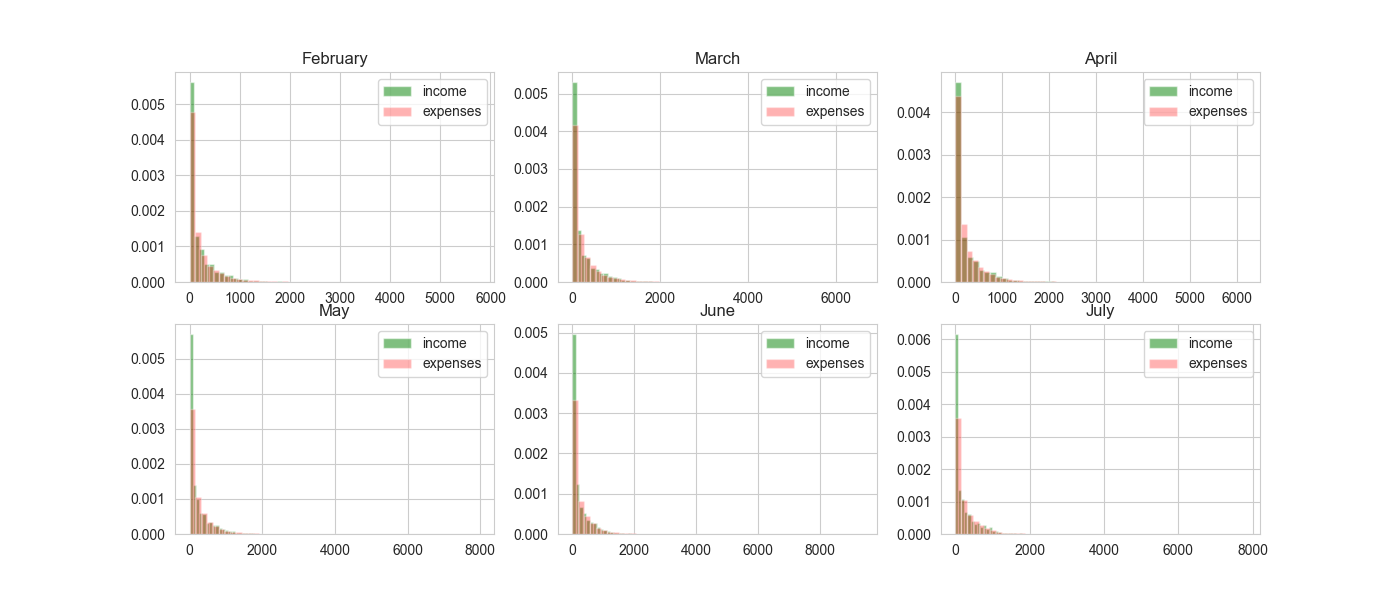

In [6]:
plot_monthly_finance_distributions(user_finances, 'in', 'out', 'income', 'expenses', log_transform=False)

<IPython.core.display.Javascript object>


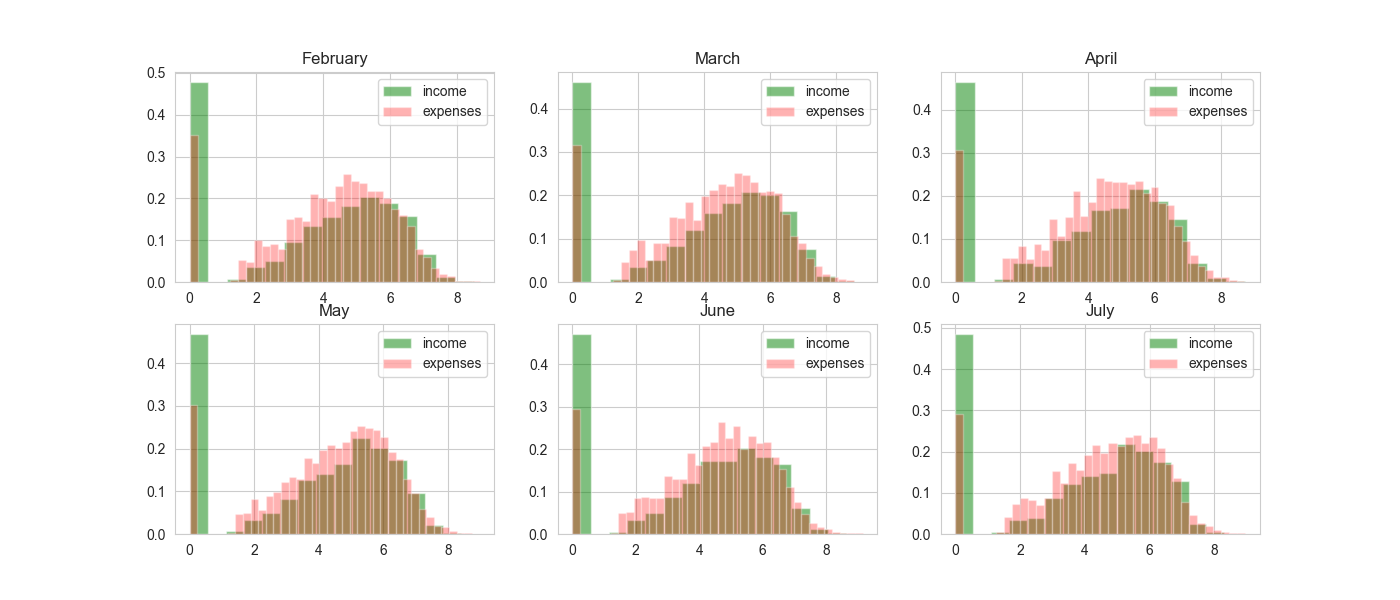

In [8]:
plot_monthly_finance_distributions(user_finances, 'in', 'out', 'income', 'expenses', log_transform=True)

<IPython.core.display.Javascript object>


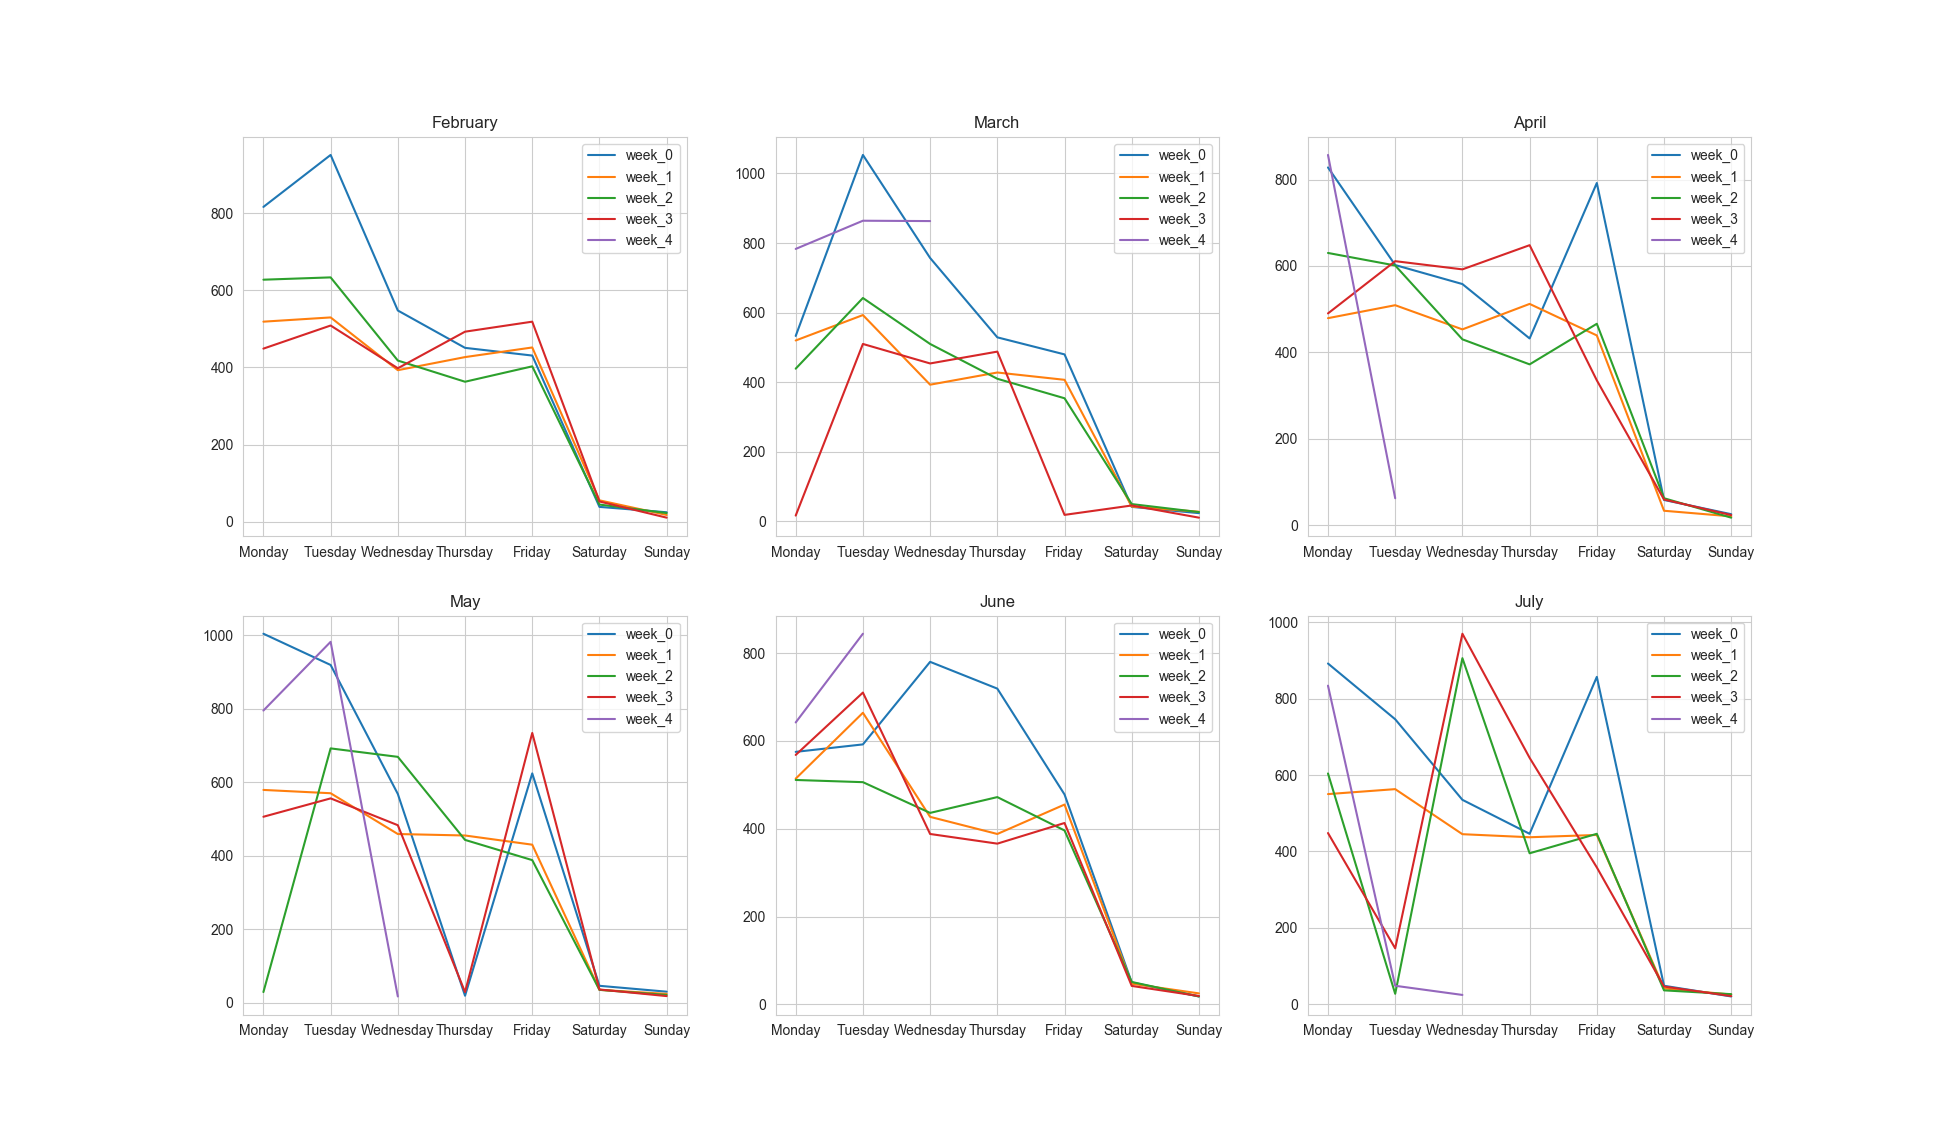

In [14]:
plot_week_over_week_transactions(ds, direction='in', transaction_type=None)

<IPython.core.display.Javascript object>


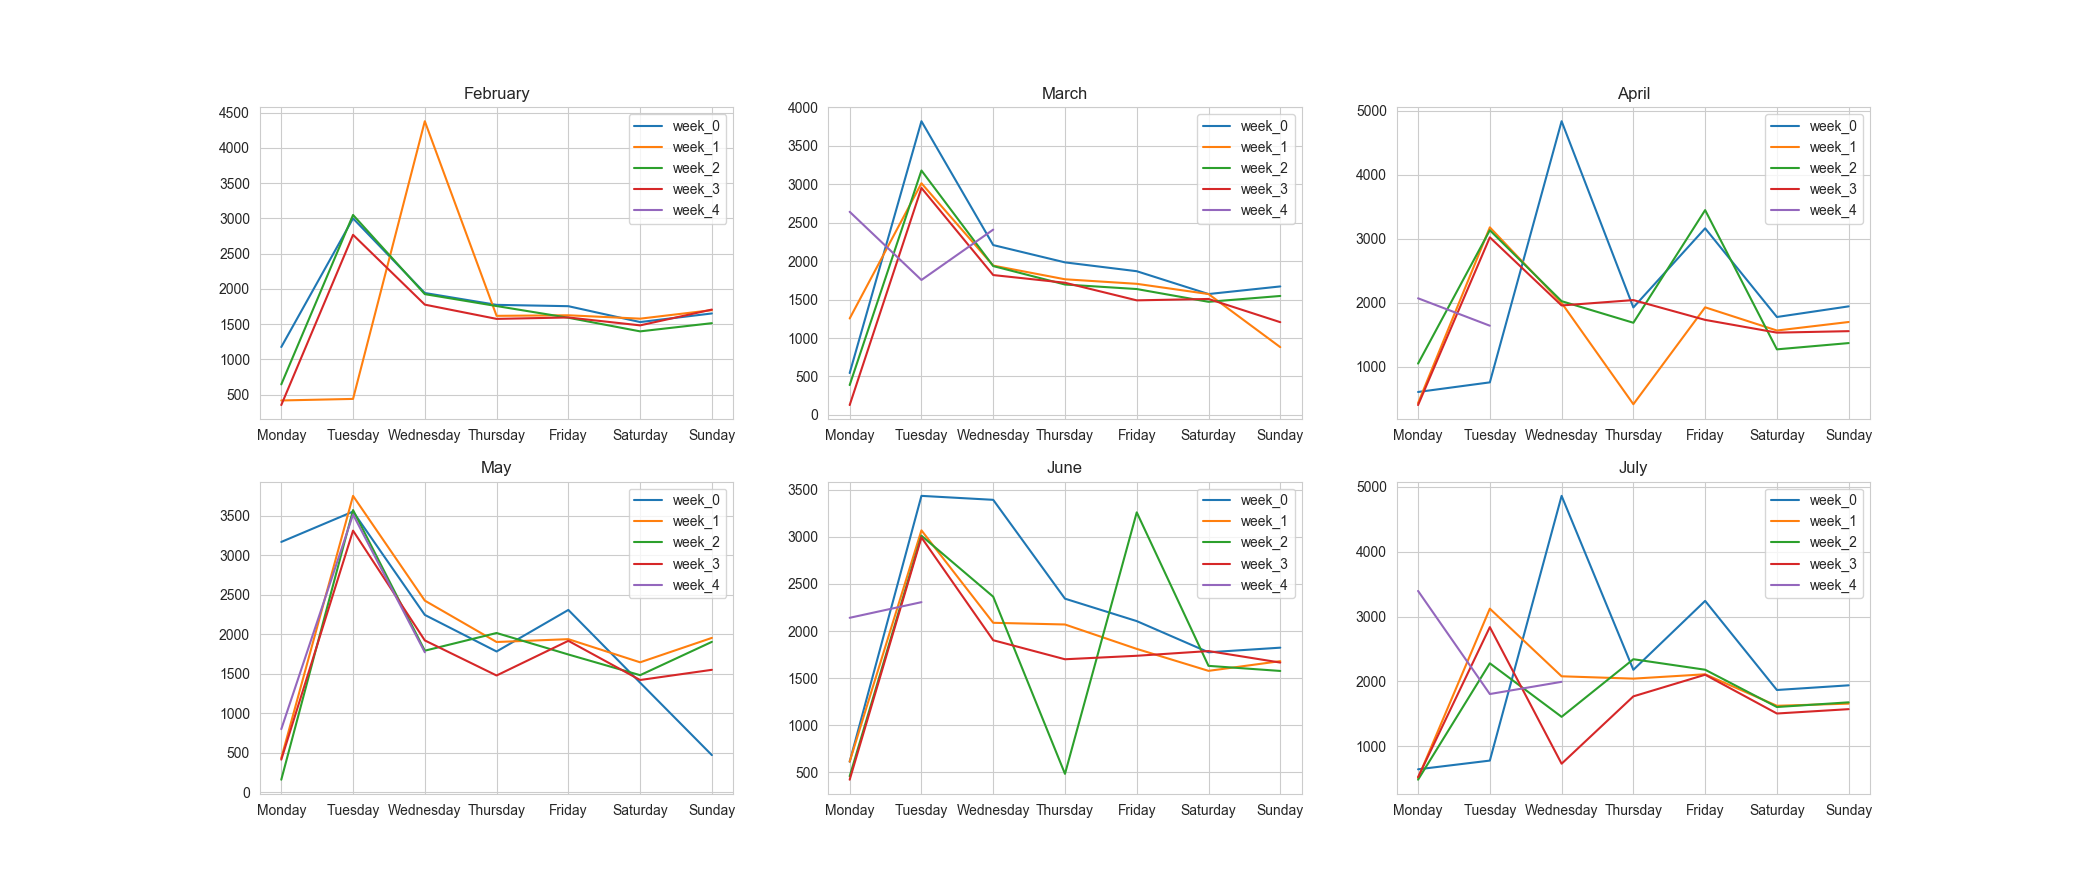

In [16]:
plot_week_over_week_transactions(ds, direction='out')

<IPython.core.display.Javascript object>


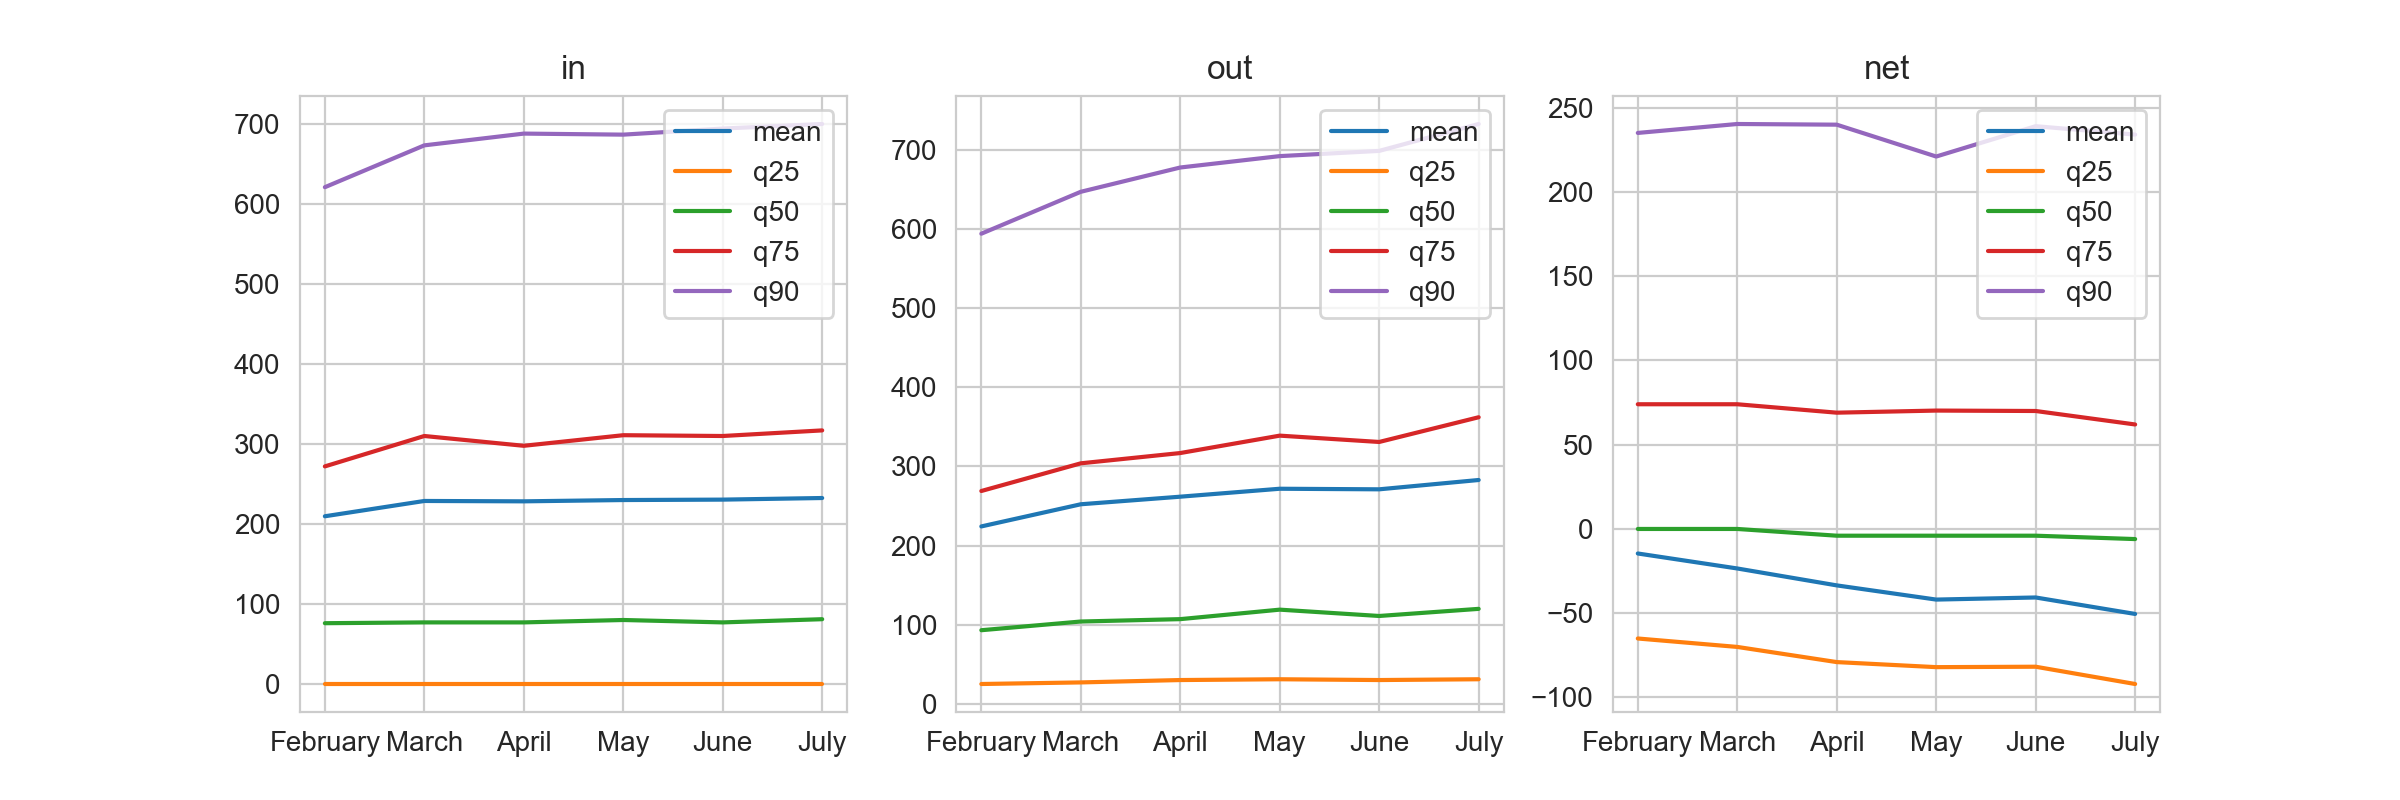

In [20]:
visualize_finances(user_finances)

<IPython.core.display.Javascript object>


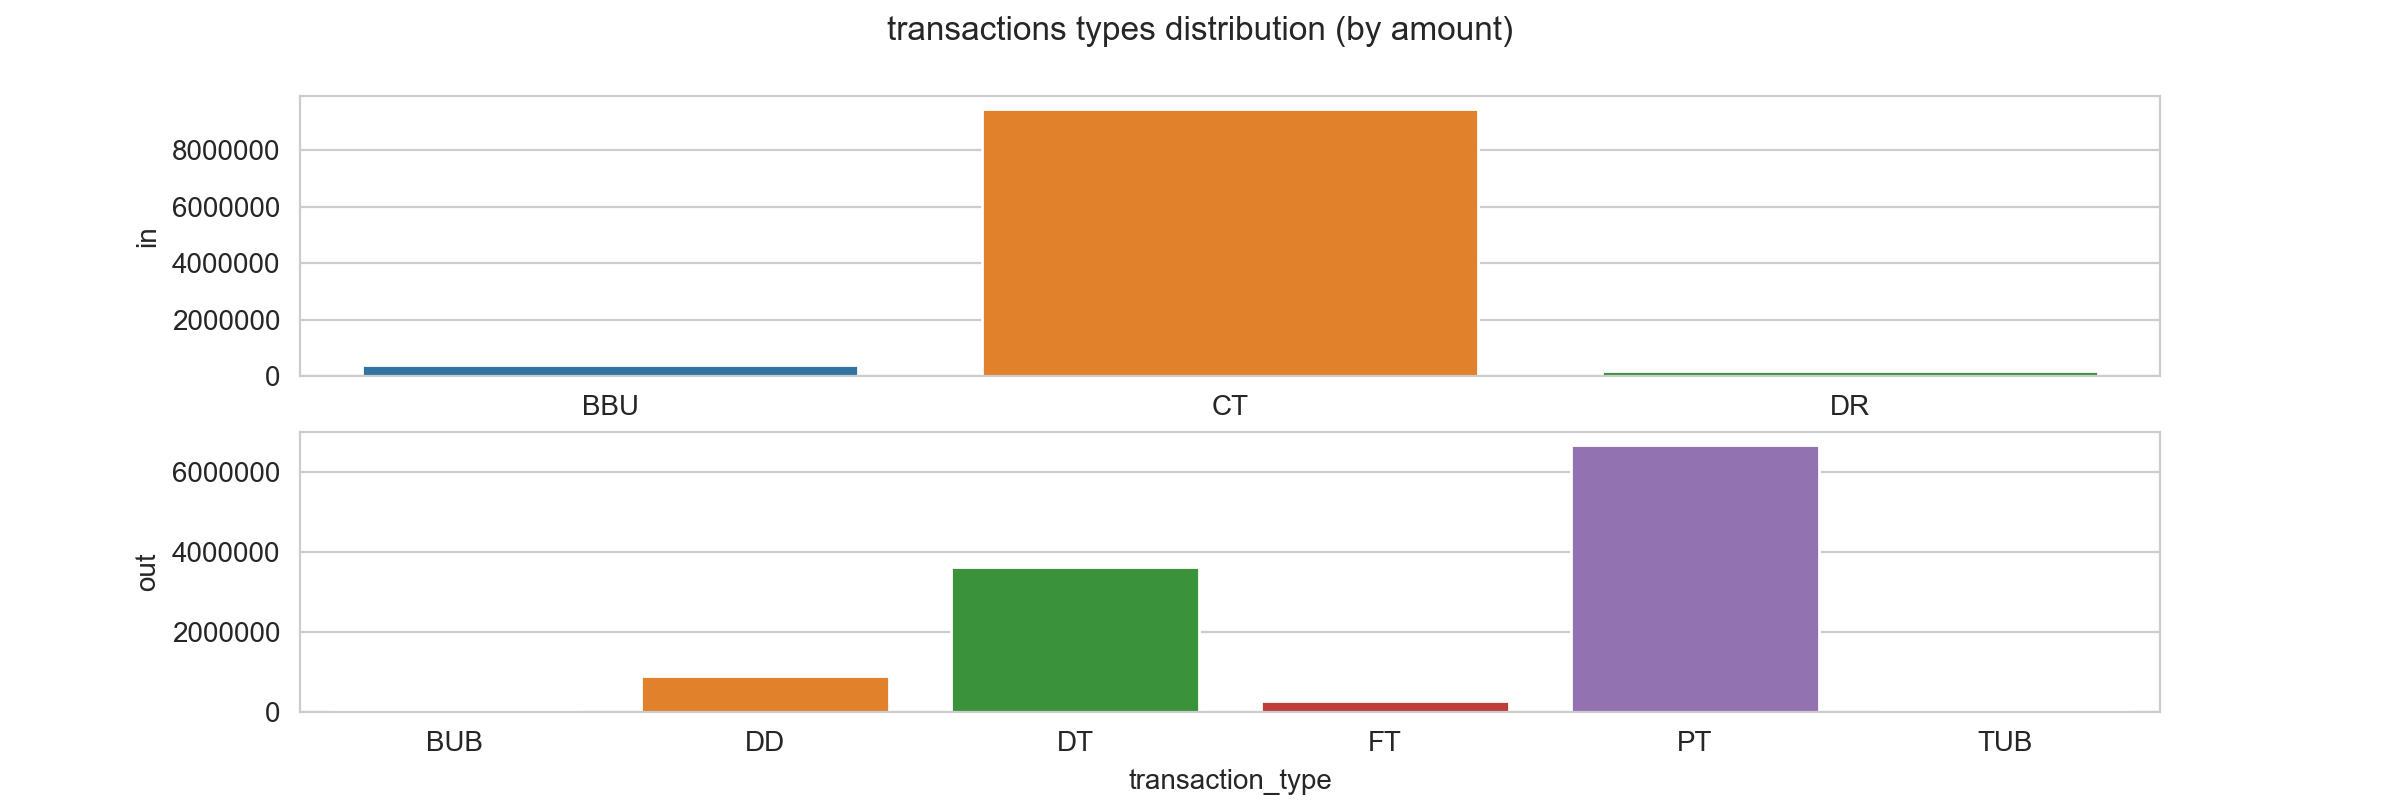

In [36]:
plot_transaction_type_dist(ds, amount=True)

<IPython.core.display.Javascript object>


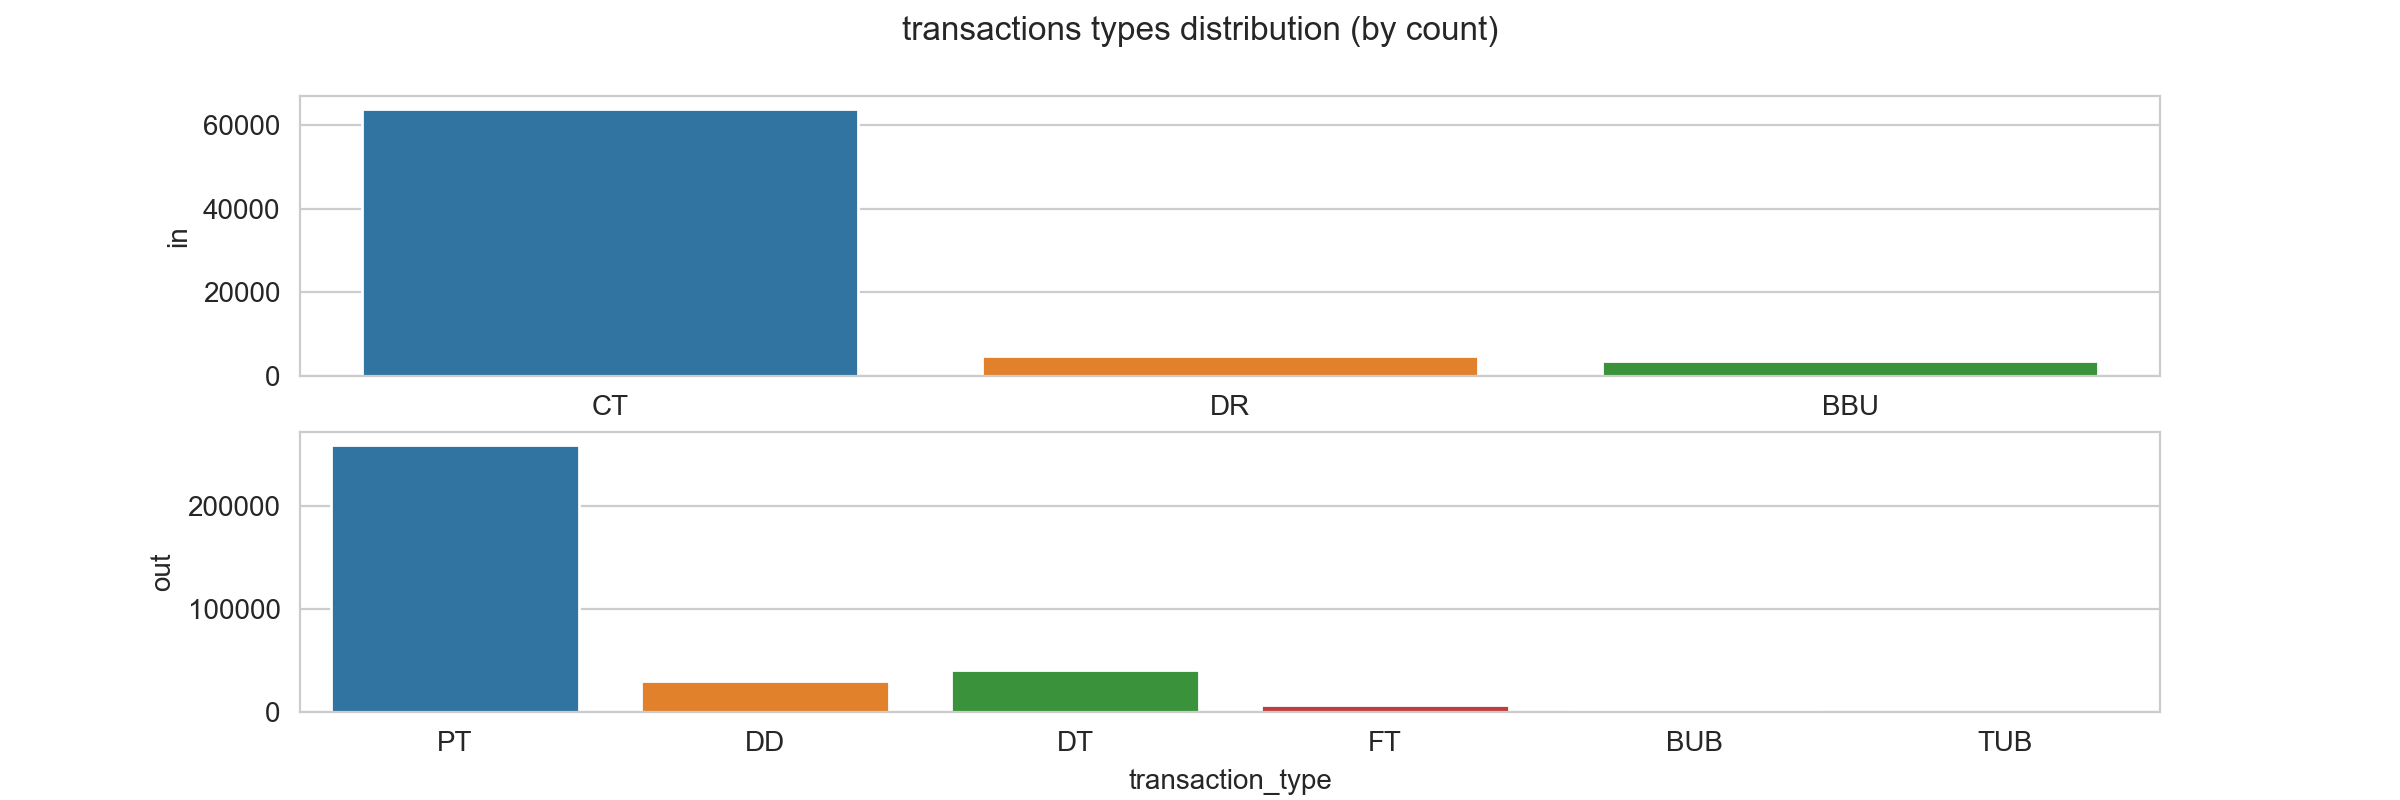

In [37]:
plot_transaction_type_dist(ds, amount=False)

## Feature Creation
----
todo

In [39]:
transaction_types = ['PT', 'DT', 'CT', 'DD', 'DR', 'FT', 'BBU', 'BUB', 'TUB']


def compute_transaction_type_features(ds, transaction_types=transaction_types):
    """Computes the amount of times each type was used by the user
    
    The occuring transactions types in our dataset are
    ['PT', 'DT', 'CT', 'DD', 'DR', 'FT', 'BBU', 'BUB', 'TUB']
    """
    feature_vectors = dict()
    groups = ds.groupby(['user_id', 'transaction_type']).transaction_date.count()
    cache = {u: {t: 0 for t in transaction_types} for u in ds.user_id.unique()}
    for (user, t), count in zip(groups.index, groups.values):
        cache[user][t] += count
        
    for user, counts in cache.items():
        feature_vectors[user] = [counts[t] for t in transaction_types]
    return feature_vectors


def compute_transaction_freq_features(ds, daysinmonth):
    """Computes statistics like the mean transaction frequency per day
    In and Out transactions are not being treated differently
    
    Stats computed: mean, max, 90th percentile
    """
    # there is some duplication here, but we'd like those function to be atomic
    feature_vectors = dict()
    groups = ds.groupby(['user_id', 'transaction_date']).transaction_date.count()
    cache = defaultdict(list)
    for (user, date), count in zip(groups.index, groups.values):
        cache[user].append(count)
    
    for user in ds.user_id.unique():
        transactions_per_day = cache[user] + [0 for _ in range(daysinmonth - len(cache[user]))]
        feature_vectors[user] = [
            np.mean(transactions_per_day),
            np.max(transactions_per_day),
            np.percentile(transactions_per_day, 90),
        ]
    return feature_vectors


def compute_dayofweek_histogram(ds):
    """Computes two histograms corresponding to Incoming/Outgoing amount per day of week
    Since a user can have only In or Out transaction, an vector of all zeros is a possible output
    """
    groups = ds.groupby(['user_id', 'transaction_date', 'transaction_direction']).amount_n26_currency.sum()
    week_in_dist, week_out_dist = dict(), dict()
    
    for (user, date, direction), amount in zip(groups.index, groups.values):
        dist = week_in_dist if direction == 'In' else week_out_dist
        if user not in dist:
            dist[user] = [0 for _ in range(7)]
        dist[user][date.dayofweek] += amount
    
    for user in ds.user_id.unique():
        for dist in [week_in_dist, week_out_dist]:
            if user not in dist:
                dist[user] = [0 for _ in range(7)]
            else:
                total = sum(dist[user])
                dist[user] = [v / total for v in dist[user]]
    return week_in_dist, week_out_dist

                
def compute_quarter_histogram(ds):
    """Computes two histograms with 4 bins. Each bin corresponds to a quarter of the month.
    We naively split the month in four buckets i.e. [1-7, 8-14, 15-21, 21-end]. This creates
    an inconsistency with regards to the last bucket. A better al could be to split based
    on week on the month.
    """
    def quarter_in_month(day):
        if day <= 7:
            return 0
        elif day <= 14:
            return 1
        elif day <= 21:
            return 2
        else:
            return 3
    groups = ds.groupby(['user_id', 'transaction_date', 'transaction_direction']).amount_n26_currency.sum()
    quart_in_dist, quart_out_dist = dict(), dict()
    
    for (user, date, direction), amount in zip(groups.index, groups.values):
        dist = quart_in_dist if direction == 'In' else quart_out_dist
        if user not in dist:
            dist[user] = [0 for _ in range(4)]
        dist[user][quarter_in_month(date.day)] += amount
    
    for user in ds.user_id.unique():
        for dist in [quart_in_dist, quart_out_dist]:
            if user not in dist:
                dist[user] = [0 for _ in range(4)]
            else:
                total = sum(dist[user])
                dist[user] = [v / total for v in dist[user]]
    return quart_in_dist, quart_out_dist

In [40]:
def compute_feature_vectors(ds):
    """Invokes all the feature calculation methods and creates
    a single feature vector for each (month, user) pair
    """
    feature_vectors = {m: defaultdict(list) for m in months}
    occuring_transaction_types = ds.transaction_type.unique()

    for month in ds.month.unique():
        _ds = ds[ds.month == month]
        daysinmonth = _ds.transaction_date.iloc[0].daysinmonth
    
        # Features: counts of transactions types per user per month
        transaction_type_features = compute_transaction_type_features(_ds)
        # Features: stats on transaction frequency (combined In/Out)
        transaction_freq_features = compute_transaction_freq_features(_ds, daysinmonth)
        # Features: histograms for day of week of In/Out transactions
        dayofweek_histograms = compute_dayofweek_histogram(_ds)
        # Features: histograms for quarter of the month In/Out transactions
        quarter_histograms = compute_quarter_histogram(_ds)

        for user in _ds.user_id.unique():
            feature_vectors[month][user] += transaction_type_features[user]
            feature_vectors[month][user] += transaction_freq_features[user]
            feature_vectors[month][user] += dayofweek_histograms[0][user]
            feature_vectors[month][user] += dayofweek_histograms[1][user]
            feature_vectors[month][user] += quarter_histograms[0][user]
            feature_vectors[month][user] += quarter_histograms[1][user]
    return feature_vectors


feature_vectors = compute_feature_vectors(ds)

In [41]:
plot_features_correlation(feature_vectors)

NameError: name 'pd' is not defined

In [ ]:


plot_features_correlation(feature_vectors)

In [ ]:
metric_labels = {0: 'low', 1: 'student', 2: 'medium', 3: 'high'}

def finance_status_accuracy(y_true, y_pred):
    def category(income):
        if income <= 150:
            return 0
        elif income <= 500:
            return 1
        elif income <= 1500:
            return 2
        else:
            return 3
    
    y_true = np.array(list(map(category, y_true)))
    y_pred = np.array(list(map(category, y_pred)))
    result = {}
    for k, v in metric_labels.items():
        mask = y_true == k
        correct = (y_true[mask] == y_pred[mask]).astype(int)
        result[v] = round(np.sum(correct) / correct.shape[0], 4), y_true[mask].shape[0]
    return result


def preciness(y_true, y_pred, threshold=.2):
    """Measures the percentage of times our predictions was in the range [true +/- true + (true * threshold)]
    """
    y_true_upper = y_true + y_true * threshold
    y_true_lower = y_true - y_true * threshold
    
    correct = np.logical_and(y_pred >= y_true_lower, y_pred <= y_true_upper).astype(int)
    return np.sum(correct) / correct.shape[0]


In [ ]:
classifiers = {
    'baseline': None,  # our baseline predictor will be returning the median of the training set
    'RF': TransformedTargetRegressor(
        regressor=RandomForestRegressor(n_estimators=400, max_depth=10, max_features=10, min_samples_leaf=4, random_state=42),
        func=np.log1p, inverse_func=np.expm1
    ),
    'Lasso': make_pipeline(
        PolynomialFeatures(2),
        StandardScaler(),
        TransformedTargetRegressor(
            regressor=LassoCV(random_state=42, max_iter=1e3),
            func=np.log1p, inverse_func=np.expm1),
    ),
}

In [ ]:
# Auxiliary functions for the training iterations
def split_dataset(user_finances, month, holdout_users):
    """explain splitting explain removal of zeros
    """
    train = user_finances[(user_finances.month != month) & ~user_finances.user_id.isin(holdout_users)]
    val = user_finances[(user_finances.month == month) & ~user_finances.user_id.isin(holdout_users)]
    test = user_finances[(user_finances.month == month) & user_finances.user_id.isin(holdout_users)]

    train_in, train_out = train[train['in'] != 0], train[train['out'] != 0]
    val_in, val_out = val[val['in'] != 0], val[val['out'] != 0]
    test_in, test_out = test[test['in'] != 0], test[test['out'] != 0]
    return train_in, train_out, val_in, val_out, test_in, test_out


def get_X_y(ds, feature_vectors, direction):
    X = []
    for m, u in zip(ds.month.values, ds.user_id.values):
        X.append(feature_vectors[m][u])
    return np.array(X), ds[direction].values

In [ ]:
# holdout sample of users for validation
np.random.seed(42)
holdout_users = set(np.random.choice(user_finances.user_id.unique(), size=1000, replace=False))

rmse = lambda y_t, y_p: np.sqrt(mse(y_t, y_p))
rmsle = lambda y_t, y_p: np.sqrt(msle(y_t, y_p))

# LOO (leave one-month-out approach)
classifiers_perf = {
    classifier: {
        month: {
            'in':  {'train': {}, 'validation': {}, 'holdout': {}, 'model': None},
            'out': {'train': {}, 'validation': {}, 'holdout': {}, 'model': None},
        } for month in months
    } for classifier in classifiers.keys()
}


for month in months:
    _user_finances = user_finances.copy()
    train_in, train_out, val_in, val_out, test_in, test_out = split_dataset(_user_finances, month, holdout_users)
    
    X_train_in, y_train_in = get_X_y(train_in, feature_vectors, 'in')
    X_train_out, y_train_out = get_X_y(train_out, feature_vectors, 'out')
    
    X_val_in, y_val_in = get_X_y(val_in, feature_vectors, 'in')
    X_val_out, y_val_out = get_X_y(val_out, feature_vectors, 'out')
    
    X_test_in, y_test_in = get_X_y(test_in, feature_vectors, 'in')
    X_test_out, y_test_out = get_X_y(test_out, feature_vectors, 'out')
    
    for name, clf in classifiers.items():
        if name != 'baseline':
            clf_in, clf_out = clone(clf), clone(clf)
            clf_in.fit(X_train_in, y_train_in)
            clf_out.fit(X_train_out, y_train_out)
            
        for k, features_in, target_in, features_out, target_out in [
            ('train', X_train_in, y_train_in, X_train_out, y_train_out),
            ('validation', X_val_in, y_val_in, X_val_out, y_val_out),
            ('holdout', X_test_in, y_test_in, X_test_out, y_test_out),
        ]:
            if name == 'baseline':
                y_predict_in = np.full(target_in.shape, np.median(y_train_in))
                y_predict_out = np.full(target_out.shape, np.median(y_train_out))
            else:
                y_predict_in = np.maximum(clf_in.predict(features_in), np.zeros(features_in.shape[0]))
                y_predict_out = np.maximum(clf_out.predict(features_out), np.zeros(features_out.shape[0]))
                
            if month == 'July' and k == 'validation' and name != 'baseline':
                plot_regressor_output(target_in, y_predict_in, '{}_income_model'.format(name))
                plot_regressor_output(target_out, y_predict_out, '{}_expenses_model'.format(name))

            for metric, func in [
                ('rmse', rmse), ('rmsle', rmsle), ('r2', r2_score), ('mae', mae), ('preciseness', preciness)
            ]:
                classifiers_perf[name][month]['in'][k][metric] = func(target_in, y_predict_in)
                classifiers_perf[name][month]['out'][k][metric] = func(target_out, y_predict_out)

            classifiers_perf[name][month]['in'][k]['residuals'] = target_in - y_predict_in
            classifiers_perf[name][month]['out'][k]['residuals'] = target_out - y_predict_out
            
            # storing the models for later use
            if name != 'baseline':
                classifiers_perf[name][month]['in']['model'] = clf_in
                classifiers_perf[name][month]['out']['model'] = clf_out
                

In [ ]:
compare_model_performance('rmsle', classifiers_perf)

In [ ]:
plot_residual_distribution(classifiers_perf, 'in')

In [ ]:
plot_residual_distribution(classifiers_perf, 'out')

## Evaluate model on Holdout Dataset

In [ ]:
# using the RandomForest model that was trained on months Feb-June
income_predictor = classifiers_perf['rf']['June']['in']['model']
expenses_predictor = classifiers_perf['rf']['June']['out']['model']


def evaluate_algorithm(income_predictor, expenses_predictor, ds=None):
    # XXX: test this
    if isinstance(ds, str):
        if dataset.endswith('.csv'):
            ds = pd.read_csv(ds)
            ds = transform_dataset(ds)
    # creating the dataset with target vars. The targets are the aggregated
    # incoming and outgoing amounts for each user each month
    user_finances, _, _ = create_income_expenses_df(ds)
    
    # log transforming the target vars to mitigate skewed distribution
    user_finances['in'] = user_finances.copy()['in'].apply(lambda f: np.log1p(f))
    user_finances['out'] = user_finances.copy()['out'].apply(lambda f: np.log1p(f))
    
    feature_vectors = compute_feature_vectors(ds)
    X = []
    for m, u in zip(user_finances.month.values, user_finances.user_id.values):
        X.append(feature_vectors[m][u])
    X = np.array(X)
    
    y_pred_in = income_predictor.predict(X)
    y_pred_out = expenses_predictor.predict(X)
    
    plot_residuals(np.exp(user_finances['in'].values) - 1, np.exp(y_pred_in) - 1)
    plot_residuals(np.exp(user_finances['out'].values) - 1, np.exp(y_pred_out) - 1)

    
    for y_true, y_pred in [(y_pred_in, user_finances['in'].values), (y_pred_out, user_finances['out'].values)]:
        y_true, y_pred = np.exp(y_true) - 1, np.exp(y_pred) - 1
        print(round(mae(y_true, y_pred), 4))
        print(round(rmsle(y_true, y_pred), 4))
        print(round(r2_score(y_true, y_pred), 4))
        print(round(preciness(y_true, y_pred), 4))
        print(finance_status_accuracy(y_true, y_pred))

evaluate_algorithm(income_predictor, expenses_predictor, ds[ds.month == 'July'])